# **STUDENT AI** - MATH MODEL CREATION (CLASSIFICATION)

## Objectives

Create a classification model to predict Math score based on Key dataset features. Numerical variables will be grouped into bins. <br> 
Since the 3 bin classification did not yield promising results, the same steps will be repeated using the 2 bin classification.

## Inputs

Continues to assess dataset loaded in previous notebook.

## Outputs

Pipeline and .pkl file to use for predicting a students math score based on the derived calculated best feature variables.


---

## Build Pipeline for classification model to predict Math numerical target variable

The steps for a classification model are a little more involved when using a dataset with a numerical target variable

| Step |  Purpose | 
|---|---|
|Data Cleaning|Deal with missing data or wrong data - step already completed in the saved dataset|
|Discretize Numerical Target|group target variable into bins for categorization|
|Encode Categorical Features|Model algorithms can only handle numerical data. Needs to be converted first|
|Feature Scaling|Ensure all numerical data has a similar scale and is centered around zero - neccessary / improves model performance|
|Data Balancing|Classification models are affected negatively by imbalanced data. SMOTE or Undersampling needs to be performed to balance the dataset|
|Feature Smart Correlation|Determine which features are most significant and eliminate uneccessary ones - helps prevent overfitting - not neccesary|
|Feature Selection|Select which features will be used |
|Algorithm Selection|Assess best algorithm for the data set as well as the best associated Parameters and Hyperparameters|
|Model Training|Train the model on the train data and evaluate with the test set|


# Import required libraries

In [1]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

### Pipeline
from sklearn.pipeline import Pipeline

### Feature Engineering
from feature_engine.encoding import OrdinalEncoder

### Feature Scaling
from sklearn.preprocessing import StandardScaler

### libraries for custom transformer
from sklearn.base import BaseEstimator, TransformerMixin

### Feature Balancing
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

### Feature  Selection
from sklearn.feature_selection import SelectFromModel

### ML algorithms 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier

### EqualFrequencyDiscretiser
from feature_engine.discretisation import EqualFrequencyDiscretiser

### packages for classification report and confusion matrix
from sklearn.metrics import make_scorer, recall_score

### Train test split
from sklearn.model_selection import train_test_split

### Packages for generating a classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

### GridSearchCV
from sklearn.model_selection import GridSearchCV

print('All Libraries Loaded')

All Libraries Loaded


# Change working directory

### Set the working directory to notebook parent folder
If the output does not match, click **'clear all outputs'** and then **'restart'** the notebook. 
Then run cells from top to bottom.

In [2]:
current_dir = os.getcwd()
os.chdir(os.path.dirname(current_dir))
current_dir = os.getcwd()
print('If correct, Active Directory should read: /workspace/student-AI')
print(f"Active Directory: {current_dir}")

If correct, Active Directory should read: /workspace/student-AI
Active Directory: /workspace/student-AI


### Load cleaned dataset

In [3]:
df = pd.read_csv(f"outputs/dataset/Expanded_data_with_more_features_clean.csv")
df.head()

,Gender,EthnicGroup,ParentEduc,LunchType,TestPrep,ParentMaritalStatus,PracticeSport,IsFirstChild,NrSiblings,WklyStudyHours,MathScore,ReadingScore,WritingScore
0,female,group C,bachelor's degree,standard,none,married,regularly,yes,3,< 5,71,71,74
1,female,group C,some college,standard,none,married,sometimes,yes,0,5 - 10,69,90,88
2,female,group B,master's degree,standard,none,single,sometimes,yes,4,< 5,87,93,91
3,male,group A,associate's degree,free/reduced,none,married,never,no,1,5 - 10,45,56,42
4,male,group C,some college,standard,none,married,sometimes,yes,0,5 - 10,76,78,75


nrSiblings is treated as a numerical variable. As I determined previously it has no bearing on the target variables, so I will drop it rather than convert to categorical. The other variables previously identified in the EDA as having not much impact, I will keep in, as the Feature Selection step did not suggest to eliminate any.

In [4]:
# df['NrSiblings'] = df['NrSiblings'].astype(str)
# 'ParentMaritalStatus', 'PracticeSport','IsFirstChild','NrSiblings','WklyStudyHours'
df_math = df.drop(['ReadingScore', 'WritingScore','NrSiblings'], axis=1)
df_math.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30641 entries, 0 to 30640
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Gender               30641 non-null  object
 1   EthnicGroup          30641 non-null  object
 2   ParentEduc           30641 non-null  object
 3   LunchType            30641 non-null  object
 4   TestPrep             30641 non-null  object
 5   ParentMaritalStatus  30641 non-null  object
 6   PracticeSport        30641 non-null  object
 7   IsFirstChild         30641 non-null  object
 8   WklyStudyHours       30641 non-null  object
 9   MathScore            30641 non-null  int64 
dtypes: int64(1), object(9)
memory usage: 2.3+ MB


In [5]:
def PipelineOptimization(model):
    pipeline_base = ImbPipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(
            encoding_method='arbitrary', 
            variables=[
                'Gender',
                'EthnicGroup',
                'ParentEduc',
                'LunchType',
                'TestPrep', 'ParentMaritalStatus', 'PracticeSport','IsFirstChild','WklyStudyHours'
                ])),

        #("undersample", RandomUnderSampler()),  # Assuming enough data values - another option will be SMOTE
        # ("oversample", SMOTE()),  # alternate balancing technique -- only allow one or teh other until best option is determined

        ("feature_selection", SelectFromModel(model)),

        ("model", model),

    ])

    return pipeline_base

In [6]:
models_algorithm_list = {
    "XGBClassifier": XGBClassifier(random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
}

parameters_list = {
    "XGBClassifier":{},
    "DecisionTreeClassifier":{},
    "RandomForestClassifier":{},
    "GradientBoostingClassifier":{},
    "ExtraTreesClassifier":{},
    "AdaBoostClassifier":{},
}

### Custom Confusion Matrix Function from CI Customer Churn Course

In [7]:
def confusion_matrix_and_report(x, y, pipeline, label_map):

  prediction = pipeline.predict(x)

  print('---  Confusion Matrix  ---')
  print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
        columns=[ ["Actual " + sub for sub in label_map] ], 
        index= [ ["Prediction " + sub for sub in label_map ]]
        ))
  print("\n")

  print('---  Classification Report  ---')
  print(classification_report(y, prediction, target_names=label_map),"\n")

def clf_performance(math_train_features, math_train_scores, math_test_features, math_test_scores, pipeline, label_map):
  print("#### Train Set #### \n")
  confusion_matrix_and_report(math_train_features, math_train_scores, pipeline, label_map)

  print("#### Test Set ####\n")
  confusion_matrix_and_report(math_test_features, math_test_scores, pipeline, label_map)

### Custom Hyperparameter search class (same as previous notebook)

To select the best algorithm and hyperparameters we will fit a model with each different type / parameter set and compare the results.
To do this I can use the custom parameter test function, derived in the CodeInstitute Churnometer Walkthrough [here](https://github.com/AdamBoley/churnometer/blob/main/jupyter_notebooks/06%20-%20Modeling%20and%20Evaluation%20-%20Predict%20Tenure.ipynb)

In [8]:
from sklearn.model_selection import GridSearchCV
class HyperparameterOptimizationSearch:

    def __init__(self, models, parameters):
        self.models = models
        self.parameters = parameters
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, x, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model =  PipelineOptimization(self.models[key])

            parameters = self.parameters[key]
            grid_search = GridSearchCV(model, parameters, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring)
            grid_search.fit(x, y)
            self.grid_searches[key] = grid_search

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, parameters):
            summary = {
                 'estimator': key,
                 'minimum_score': min(scores),
                 'maximum_score': max(scores),
                 'mean_score': np.mean(scores),
                 'standard_deviation_score': np.std(scores),
            }
            return pd.Series({**parameters,**summary})

        rows = []
        for k in self.grid_searches:
            parameters = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                result = self.grid_searches[k].cv_results_[key]        
                scores.append(result.reshape(len(parameters), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(parameters, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'minimum_score', 'mean_score', 'maximum_score', 'standard_deviation_score']
        columns = columns + [column for column in df.columns if column not in columns]

        return df[columns], self.grid_searches

### Create custom transformer to discretize the dataframe based on 5, 3 or 2 bins.
Criteria for boundaries is based on calculated mean and standard deviation.

In [9]:
class CustomDiscretizer(BaseEstimator, TransformerMixin):
    """
    Custom Transformer to automatically generate categorical bins from a numerical variable
    Arguments are a pandas dataframe, the number of bins and the column(s) to discretize
    bins are sized based on the column mean value and standard deviation
    2 bins are spit at the mean
    3 bins are split +- 1/2 the SD
    5 bins are split at the  mean with 1*SD and 2*Sd as the cutoff
    If wrong bin argument is given, defaults to 5
    No column arg = use all columns (default)
    """
    def __init__(self, n_bins=3, columns=None):
        if n_bins not in [2, 3, 5]:
            print("Error: n_bins must be : [2, 3 or 5]. Setting 5 as default.")
            self.n_bins = 5  # Default
        else:
            self.n_bins = n_bins
        self.columns = columns
    
    def fit(self, X, y=None):
        # not needed
        return self
    
    def transform(self, X):
        # Ensure X is a DataFrame
        X_transformed = X.copy()
        # If columns param is None, apply to all columns
        columns_to_discretize = self.columns if self.columns is not None else X.columns
        
        for column in columns_to_discretize:
            if column in X.columns:  # Check column exists
                mean = X[column].mean()
                std = X[column].std()
                min_val = X[column].min()
                max_val = X[column].max()

                if self.n_bins == 5:
                    bins = [min_val-1, mean - 2*std, mean - std, mean, mean + std, max_val+1]
                    labels = [0, 1, 2, 3, 4]
                
                elif self.n_bins == 3:
                    bins = [min_val-1, mean - std/2, mean + std/2, max_val+1]
                    labels = [0, 1, 2]
                
                elif self.n_bins == 2:
                    bins = [min_val-1, mean, max_val+1]
                    labels = [0, 1]

                X_transformed[column] = pd.cut(X[column], bins=bins, labels=labels, include_lowest=True)
            else:
                # If the column is not in the DataFrame,  raise an error or warn
                print(f"Column {column} not found in DataFrame!")
        
        return X_transformed

#### Test CustomDiscretizer

In [10]:
discretizer = CustomDiscretizer(n_bins=2, columns=['MathScore'])
df_transformed = discretizer.fit_transform(df_math)
df_transformed.head()


,Gender,EthnicGroup,ParentEduc,LunchType,TestPrep,ParentMaritalStatus,PracticeSport,IsFirstChild,WklyStudyHours,MathScore
0,female,group C,bachelor's degree,standard,none,married,regularly,yes,< 5,1
1,female,group C,some college,standard,none,married,sometimes,yes,5 - 10,1
2,female,group B,master's degree,standard,none,single,sometimes,yes,< 5,1
3,male,group A,associate's degree,free/reduced,none,married,never,no,5 - 10,0
4,male,group C,some college,standard,none,married,sometimes,yes,5 - 10,1


### Visualize custom created bins

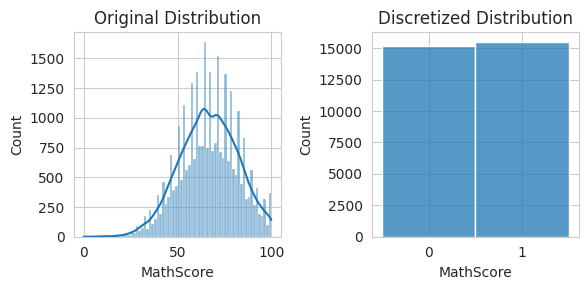

In [11]:
plt.figure(figsize=(6, 3))

# Original distribution
plt.subplot(1, 2, 1)
sns.histplot(df['MathScore'], bins='auto', kde=True)
plt.title('Original Distribution')

# Discretized distribution
plt.subplot(1, 2, 2)
sns.histplot(df_transformed['MathScore'], bins='auto', kde=False)
plt.title('Discretized Distribution')

plt.tight_layout()
plt.show()

### Start model tests

In [12]:
math_train_features, math_test_features, math_train_scores, math_test_scores = train_test_split(
    df_transformed.drop(['MathScore'], axis=1),
    df_transformed['MathScore'],
    test_size = 0.2,
    random_state = 7
)

print("* Train set:", math_train_features.shape, math_train_scores.shape, "\n* Test set:",  math_test_features.shape, math_test_scores.shape)

* Train set: (24512, 9) (24512,) 
* Test set: (6129, 9) (6129,)


### Check distribution of training set

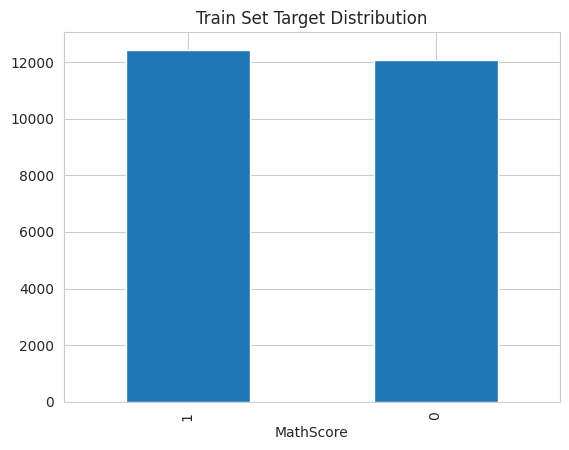

In [13]:
sns.set_style("whitegrid")
math_train_scores.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

### Balance Data
This plot shows the data is a little imbalanced. Since there are manny data rows, I will again use random under smapling to balance the training set.

In [14]:
undersample = RandomUnderSampler(random_state=0)
math_train_features, math_train_scores = undersample.fit_resample(math_train_features, math_train_scores)
print(math_train_features.shape, math_train_scores.shape)

(24168, 9) (24168,)


### Check balanced plot...

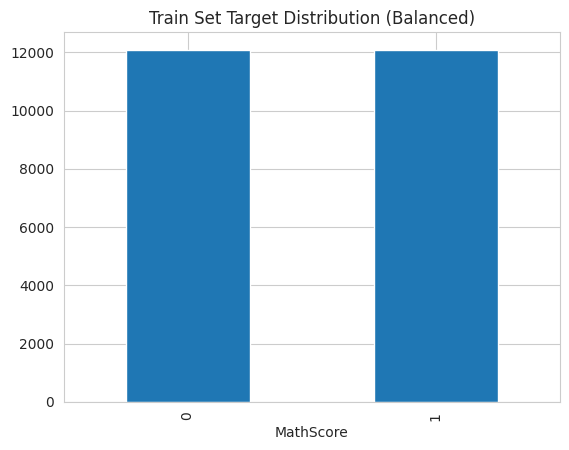

In [15]:
math_train_scores.value_counts().plot(kind='bar', title='Train Set Target Distribution (Balanced)')
plt.show()

### Analysis
This plot shows the resulting Target distribution is now well balanced with only a small reduction in data rows.

In [16]:
model_search = HyperparameterOptimizationSearch(models=models_algorithm_list, parameters=parameters_list)
model_search.fit(math_train_features, math_train_scores, scoring=make_scorer(recall_score, labels=[0], average=None), n_jobs=-1, cv=5)



Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [17]:
model_grid_search_summary, model_grid_search_pipelines = model_search.score_summary(sort_by='mean_score')
model_grid_search_summary

,estimator,minimum_score,mean_score,maximum_score,standard_deviation_score
5,AdaBoostClassifier,0.618122,0.640433,0.660323,0.013602
1,DecisionTreeClassifier,0.592301,0.61544,0.635912,0.016544
4,ExtraTreesClassifier,0.580058,0.600876,0.620604,0.014212
2,RandomForestClassifier,0.571783,0.595249,0.617708,0.016781
3,GradientBoostingClassifier,0.580058,0.592601,0.621018,0.014809
0,XGBClassifier,0.486554,0.494207,0.502689,0.005706


### Analysis
Reducing the bins to 3 changed the result of the algorithm search to AdaBoostClassifier with a mean score of 0.604. This is at the desired value of 0.6 and not very promising. XGBBoost is only slightly lower at 0.567 so it is possible with some optimized hyperparameters that it might achieve a better result. The next step will therfore use the 2 best Classifiers and generate results for different hyperparameter combinations to see if the value can be improved.

### Define Hyperparameter list for 2 best models and apply to evaluate the best options

In [19]:
best_models = {
    # "XGBClassifier": XGBClassifier(random_state=0),
    # "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
}
 
test_parameters = {
    # "XGBClassifier":{'model__n_estimators': [30,80,200],
    #                   'model__max_depth': [None, 3, 15],
    #                   'model__learning_rate': [0.01,0.1,0.001],
    #                   'model__gamma': [0, 0.1],
    #                         },

    # "GradientBoostingClassifier":{'model__n_estimators': [100,50,140],
    #                               'model__learning_rate':[0.1, 0.01, 0.001],
    #                               'model__max_depth': [3,15, None],
    #                               'model__min_samples_split': [2,50],
    #                               'model__min_samples_leaf': [1,50],
    #                               'model__max_leaf_nodes': [None,50],
    #                         },

    "DecisionTreeClassifier":{'model__max_depth': [None,4, 15],
                              'model__min_samples_split': [2,50],
                              'model__min_samples_leaf': [1,50],
                              'model__max_leaf_nodes': [None,50],
                            },

    "AdaBoostClassifier":{'model__n_estimators': [50,25,80,150],
                          'model__learning_rate':[1,0.1, 2],
                            }
  }

In [20]:
parameters_search = HyperparameterOptimizationSearch(models=best_models, parameters=test_parameters)
parameters_search.fit(math_train_features, math_train_scores, scoring=make_scorer(recall_score, labels=[0], average=None), n_jobs=-1, cv=5)


Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 12 candidates, totalling 60 fits

Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [21]:
parameters_grid_search_summary, parameters_grid_search_pipelines = parameters_search.score_summary(sort_by='mean_score')
parameters_grid_search_summary

,estimator,minimum_score,mean_score,maximum_score,standard_deviation_score,model__learning_rate,model__n_estimators,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split
9,AdaBoostClassifier,0.869673,0.913689,0.930464,0.022335,2,25,NaN,NaN,NaN,NaN
4,AdaBoostClassifier,0.6024,0.759851,0.811336,0.07898,0.1,50,NaN,NaN,NaN,NaN
5,AdaBoostClassifier,0.6024,0.759851,0.811336,0.07898,0.1,25,NaN,NaN,NaN,NaN
6,AdaBoostClassifier,0.646256,0.739161,0.774928,0.046939,0.1,80,NaN,NaN,NaN,NaN
7,AdaBoostClassifier,0.639222,0.721122,0.774928,0.054296,0.1,150,NaN,NaN,NaN,NaN
0,AdaBoostClassifier,0.618122,0.640433,0.660323,0.013602,1,50,NaN,NaN,NaN,NaN
2,AdaBoostClassifier,0.618122,0.640433,0.660323,0.013602,1,80,NaN,NaN,NaN,NaN
3,AdaBoostClassifier,0.618122,0.640433,0.660323,0.013602,1,150,NaN,NaN,NaN,NaN
1,AdaBoostClassifier,0.618122,0.635965,0.645428,0.009335,1,25,NaN,NaN,NaN,NaN
13,DecisionTreeClassifier,0.589818,0.616846,0.644187,0.022008,NaN,NaN,None,None,1,50


### Analysis
This is a very large improvement for the AdaBoostClassifier, now at 0.875. The XGBClassifier did not improve with different hyperparameters. I will test the model on the test data to verifiy the accuracy.

In [22]:
maths_best_model = parameters_grid_search_summary.iloc[0,0]
maths_best_model

'AdaBoostClassifier'

In [23]:
maths_best_parameters = parameters_grid_search_pipelines[maths_best_model].best_params_
maths_best_parameters

{'model__learning_rate': 2, 'model__n_estimators': 25}

In [24]:
pipeline_classifier = parameters_grid_search_pipelines[maths_best_model].best_estimator_
pipeline_classifier

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['Gender', 'EthnicGroup',
                                           'ParentEduc', 'LunchType',
                                           'TestPrep', 'ParentMaritalStatus',
                                           'PracticeSport', 'IsFirstChild',
                                           'WklyStudyHours'])),
                ('feature_selection',
                 SelectFromModel(estimator=AdaBoostClassifier(random_state=0))),
                ('model',
                 AdaBoostClassifier(learning_rate=2, n_estimators=25,
                                    random_state=0))])

* These are the 2 most important features in descending order. The model was trained on them: 
['EthnicGroup', 'ParentEduc']


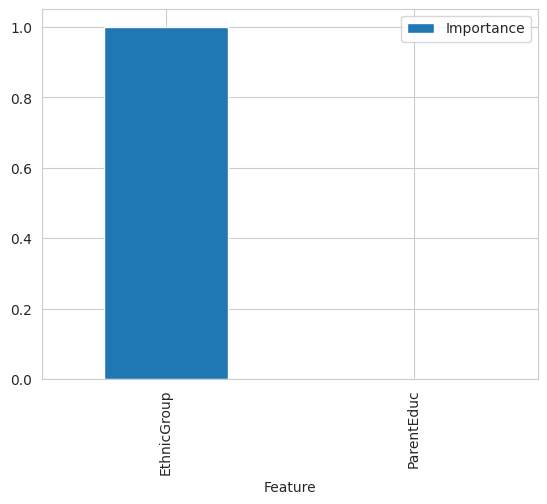

In [25]:
data_cleaning_feat_eng_steps = 1
columns_after_data_cleaning_feat_eng = (Pipeline(pipeline_classifier.steps[:data_cleaning_feat_eng_steps])
                                        .transform(math_train_features)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[pipeline_classifier['feature_selection'].get_support()].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
          'Feature': columns_after_data_cleaning_feat_eng[pipeline_classifier['feature_selection'].get_support()],
          'Importance': pipeline_classifier['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

maths_best_features = df_feature_importance['Feature'].to_list() # reassign best features in order

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{best_features}")

df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

### Analysis
This is a surprice and very dissppointing. The LunchType Variable was not added to teh training of the model and even worse it looks like the only Feature used to predict the Math Score was the Ethnic group. Obviously that is not a very good starting point for predicitng a students performcne and would bordeline introduce discrimination. This is not a good result, despite the increast accuracy from the hyperparameter search.

In [28]:
label_map = ['Below Average','Above Average']

In [29]:
clf_performance(math_train_features, math_train_scores, math_test_features, math_test_scores, pipeline_classifier, label_map )

#### Train Set #### 

---  Confusion Matrix  ---
                         Actual Below Average Actual Above Average
Prediction Below Average                11185                 9824
Prediction Above Average                  899                 2260


---  Classification Report  ---
               precision    recall  f1-score   support

Below Average       0.53      0.93      0.68     12084
Above Average       0.72      0.19      0.30     12084

     accuracy                           0.56     24168
    macro avg       0.62      0.56      0.49     24168
 weighted avg       0.62      0.56      0.49     24168
 

#### Test Set ####

---  Confusion Matrix  ---
                         Actual Below Average Actual Above Average
Prediction Below Average                 2847                 2472
Prediction Above Average                  225                  585


---  Classification Report  ---
               precision    recall  f1-score   support

Below Average       0.54      0.93      0.6

## Conclusion
The test shows that the model is also not able to predict values in the middle of the test data set. The Recall score of 0.94 seems exceptionally high for predicting below average student exam scores ... since this is soley based on EthnicGroup, it will not be a valid model.

It looks like the data set will not allow a detaile regression or classification prediction. The last option is to at least train the model using 2 bins which will allow identification of above or below perfoming student predictions. I will apply the same flow in the next notebook.